In [39]:
import pandas as pd
import re
from itertools import chain
from tqdm.auto import tqdm
from transformers import pipeline
from datasets import Dataset  # HuggingFace dataset
import numpy as np
import matplotlib.pyplot as plt
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

## THIS SECTION IS FOR GETTING THE SENTIMENT, SKIP AHEAD TO DOWNLOAD THE DATA THAT RESULTS FROM THIS SECTION WITH SENTIMENT SCORES UNLESS YOU WANT TO ALTER THE SENTIMENT CALCULATION

In [21]:
truths = pd.read_csv('trump_truths_dataset.csv')
truths.rename(columns={'post_date': 'date', 'status_text': 'text'}, inplace=True)
truths['date'] = pd.to_datetime(truths['date'])
to_drop = ['video_urls/0', 'image_urls/0', 'video_urls/0/url',
       'video_urls/0/quality', 'video_urls/1/url', 'video_urls/1/quality',
       'video_urls/2/url', 'video_urls/2/quality', 'image_urls/1',
       'image_urls/2', 'image_urls/3', 'video_urls/3/url',
       'video_urls/3/quality', 'video_urls/4/url', 'video_urls/4/quality','profile_link', 'avatar_url', 'post_url',
       'account_name', 'account_handle', 'verified_badge', 'replies']
truths.drop(columns=to_drop, inplace=True)
truths.dropna(subset=['text'], inplace=True)
truths.head()

,date,text,shares,likes
0,2024-11-08 10:05:00,"There are fake, untrue, and probably illegal r...","1,41k","5,01k"
6,2024-11-05 22:00:00,California - 1 More Hour!Polls are open until ...,"5,38k","31,4k"
7,2024-11-05 20:58:00,Nevada - 1 More Hour!Polls are open until 7:00...,"4,18k","24,1k"
8,2024-11-05 20:58:00,Montana - 1 More Hour!Polls are open until 8:0...,"3,17k","18,3k"
9,2024-11-05 19:33:00,HI REPUBLICANS! IF YOU’RE IN LINE—STAY IN LINE…,"7,72k","37,5k"


In [25]:
tweets = pd.read_csv('trump_tweets.csv')
to_drop = ['id','isFlagged', 'device', 'isDeleted']
tweets.drop(columns=to_drop, inplace=True)
tweets.rename(columns={'favorites': 'likes', 'retweets': 'shares'}, inplace=True)
tweets['date'] = pd.to_datetime(tweets['date'])
#drop retweets
tweets = tweets[tweets['isRetweet'] == 'f']
tweets.drop(columns=['isRetweet'], inplace=True)
tweets.head()

,text,likes,shares,date
0,Republicans and Democrats have both created ou...,49,255,2011-08-02 18:07:48
1,I was thrilled to be back in the Great city of...,73748,17404,2020-03-03 01:34:50
3,The Unsolicited Mail In Ballot Scam is a major...,80527,23502,2020-09-12 20:10:58
6,Getting a little exercise this morning! https:...,285863,30209,2020-02-01 16:14:02
7,https://t.co/4qwCKQOiOw,130822,19127,2020-10-23 04:52:14


In [26]:
# combine the two datasets
combined = pd.concat([truths, tweets], ignore_index=True)
combined

,date,text,shares,likes
0,2024-11-08 10:05:00,"There are fake, untrue, and probably illegal r...","1,41k","5,01k"
1,2024-11-05 22:00:00,California - 1 More Hour!Polls are open until ...,"5,38k","31,4k"
2,2024-11-05 20:58:00,Nevada - 1 More Hour!Polls are open until 7:00...,"4,18k","24,1k"
3,2024-11-05 20:58:00,Montana - 1 More Hour!Polls are open until 8:0...,"3,17k","18,3k"
4,2024-11-05 19:33:00,HI REPUBLICANS! IF YOU’RE IN LINE—STAY IN LINE…,"7,72k","37,5k"
...,...,...,...,...
50929,2020-01-03 12:44:30,"Iran never won a war, but never lost a negotia...",57253,303007
50930,2020-01-01 01:03:15,Thank you to the @dcexaminer Washington Examin...,9213,35044
50931,2020-01-01 00:55:01,One of my greatest honors was to have gotten C...,12761,56731
50932,2020-10-22 21:04:21,Just signed an order to support the workers of...,36001,176289


In [28]:
# Helper functions and entity definitions (similar to general_users.ipynb)

def generate_aliases(person):
    first, last = person["first"], person["last"]
    full = f"{first} {last}"
    aliases = [full, first, last]
    if "nicknames" in person:
        aliases.extend(person["nicknames"])
    if "handle" in person:
        aliases.extend([person["handle"], f"@{person['handle']}"])
    return aliases

# People and slogans - can be adjusted if needed for Trump's context, but using general ones for now
dem_people = [
    {"first": "Joe", "last": "Biden", "nicknames": ["JoeBiden"], "handle": "JoeBiden"},
    {"first": "Kamala", "last": "Harris", "nicknames": ["KamalaHarris"], "handle": "KamalaHarris"},
]
rep_people = [
    {"first": "Donald", "last": "Trump", "nicknames": ["Trump"], "handle": "realDonaldTrump"},
    # Add other relevant figures if analyzing broader Republican sentiment, otherwise Trump alone is fine
]

# Entities
dem_entities = list(chain.from_iterable(generate_aliases(p) for p in dem_people)) + [
    "democrat", "democrats", "Democrats", "democratic party", "dnc", "vote blue", "blue wave", "bidenomics"
]
rep_entities = list(chain.from_iterable(generate_aliases(p) for p in rep_people)) + [
    "republican", "Republican", "republicans", "gop", "rnc", "maga", "trump2024", "drain the swamp"
]

# Regex patterns
def compile_pattern(entities):
    sorted_ents = sorted(set(entities), key=len, reverse=True)
    pat = r'\b(' + '|'.join(re.escape(ent) for ent in sorted_ents) + r')\b'
    return re.compile(pat, flags=re.IGNORECASE)

dem_pattern = compile_pattern(dem_entities)
rep_pattern = compile_pattern(rep_entities)

def truncate_sent(text, max_len=512):
    if not isinstance(text, str):
        return ""  # or return a placeholder like "[no text]"
    return text if len(text) <= max_len else text[:max_len]

tqdm.pandas()

In [30]:
# Ensure 'text' column is string type and handle NaNs
combined['text'] = combined['text'].astype(str).fillna('')

# Create HuggingFace Dataset
ds_combined = Dataset.from_pandas(combined[['text']])

# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0)  # if GPU available
# Truncate texts
truncated_texts_combined = [truncate_sent(t) for t in ds_combined['text']]

# Run sentiment analysis in batch
sentiments_combined = sentiment_analyzer(truncated_texts_combined, batch_size=32) # Adjust batch_size based on your VRAM

# Add sentiment results to the Dataset
ds_combined = ds_combined.add_column("Sentiment", sentiments_combined)

Device set to use mps:0


In [31]:
# Convert Dataset back to pandas DataFrame
df_s_combined = ds_combined.to_pandas()

# Add Score and Label to the original combined DataFrame
combined['Score'] = df_s_combined['Sentiment'].apply(lambda x: x['score'])
combined['Label'] = df_s_combined['Sentiment'].apply(lambda x: x['label'])

combined.head()

,date,text,shares,likes,Score,Label
0,2024-11-08 10:05:00,"There are fake, untrue, and probably illegal r...","1,41k","5,01k",0.996140,POSITIVE
1,2024-11-05 22:00:00,California - 1 More Hour!Polls are open until ...,"5,38k","31,4k",0.996500,NEGATIVE
2,2024-11-05 20:58:00,Nevada - 1 More Hour!Polls are open until 7:00...,"4,18k","24,1k",0.996823,NEGATIVE
3,2024-11-05 20:58:00,Montana - 1 More Hour!Polls are open until 8:0...,"3,17k","18,3k",0.996348,NEGATIVE
4,2024-11-05 19:33:00,HI REPUBLICANS! IF YOU’RE IN LINE—STAY IN LINE…,"7,72k","37,5k",0.994020,POSITIVE


In [33]:
# Check the distribution of sentiments
print(combined['Label'].value_counts())

# Display some examples
print("\nPositive examples:")
print(combined[combined['Label'] == 'POSITIVE'][['text', 'Score']].tail())

print("\nNegative examples:")
print(combined[combined['Label'] == 'NEGATIVE'][['text', 'Score']].tail())

Label
POSITIVE    25948
NEGATIVE    24986
Name: count, dtype: int64

Positive examples:
                                                    text     Score
50918  MEXICO IS PAYING FOR THE WALL through the many...  0.997372
50920  Iran is talking very boldly about targeting ce...  0.995202
50925  95% Approval Rating in the Republican Party. T...  0.999859
50929  Iran never won a war, but never lost a negotia...  0.997669
50930  Thank you to the @dcexaminer Washington Examin...  0.995695

Negative examples:
                                                    text     Score
50927  ....followed, and then it was withdrawn. The D...  0.999376
50928  ....different places that he thought were wast...  0.991819
50931  One of my greatest honors was to have gotten C...  0.987256
50932  Just signed an order to support the workers of...  0.995773
50933  Suburban women want Safety &amp; Security. Joe...  0.993172


In [34]:
# save the combined DataFrame with sentiment scores
combined.to_csv('combined_trump_sentiment.csv', index=False)


# SECTION FOR COMPARING TO MACRO DATA

In [42]:
START_DATE = '2020-10-22'
END_DATE = '2024-11-09'

In [43]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}



In [51]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': START_DATE, 'lte': END_DATE},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2020-10-22 00:00:00 to 2024-11-08 00:00:00


In [52]:
# Load the combined data with sentiment scores
# This assumes 'combined_trump_sentiment.csv' is in the same directory or path is correctly specified
sentiment_df = pd.read_csv('combined_trump_sentiment.csv')

# Helper function to convert likes/shares to numeric
def convert_to_numeric(value):
    if pd.isna(value):
        return 0
    if isinstance(value, (int, float)):
        return value
    if isinstance(value, str):
        num_str = str(value).replace(',', '').lower()
        if 'k' in num_str:
            return float(num_str.replace('k', '')) * 1000
        if 'm' in num_str:
            return float(num_str.replace('m', '')) * 1000000
        try:
            return float(num_str)
        except ValueError:
            return 0 # Return 0 if conversion fails
    return 0

# Convert 'shares' and 'likes' columns to numeric
sentiment_df['shares_numeric'] = sentiment_df['shares'].apply(convert_to_numeric)
sentiment_df['likes_numeric'] = sentiment_df['likes'].apply(convert_to_numeric)

# Convert 'date' to datetime and set as index
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df.set_index('date', inplace=True)

# Create a base numerical sentiment score
sentiment_df['BaseNumericScore'] = sentiment_df.apply(lambda row: row['Score'] if row['Label'] == 'POSITIVE' else -row['Score'], axis=1)

# Create an engagement weight
# Adding 1 inside log1p to prevent log(0) if shares and likes are both 0. log1p(x) = log(1+x)
sentiment_df['EngagementWeight'] = np.log1p(sentiment_df['shares_numeric'] + sentiment_df['likes_numeric'])

# Enhance the numeric score with engagement weight
# If EngagementWeight is 0 (shares+likes=0), NumericScore = BaseNumericScore
sentiment_df['NumericScore'] = sentiment_df['BaseNumericScore'] * (1 + sentiment_df['EngagementWeight'])


# Filter by START_DATE and END_DATE (defined in a previous cell)
sentiment_df = sentiment_df[(sentiment_df.index >= pd.to_datetime(START_DATE)) & (pd.to_datetime(sentiment_df.index) <= pd.to_datetime(END_DATE))]

# Resample to get daily mean sentiment. We only need the NumericScore.
# Taking the mean of scores if multiple posts on the same day
daily_sentiment = sentiment_df['NumericScore'].resample('D').mean().dropna()
daily_sentiment_df = daily_sentiment.to_frame(name='DailySentiment')

print("Daily Sentiment Scores (Enhanced with Engagement):")
print(daily_sentiment_df.head())
print(f"\nSentiment data from {daily_sentiment_df.index.min()} to {daily_sentiment_df.index.max()}")

Daily Sentiment Scores (Enhanced with Engagement):
            DailySentiment
date                      
2020-10-22       -2.452348
2020-10-23       -5.548369
2020-10-24       -1.682821
2020-10-25        1.972260
2020-10-26       -3.509567

Sentiment data from 2020-10-22 00:00:00 to 2024-11-08 00:00:00


In [53]:
# Prepare Asset Returns
# price_df should be available from previous cells
if 'price_df' in globals() and not price_df.empty:
    asset_returns = price_df.pct_change().dropna()
    print("\nAsset Daily Returns:")
    print(asset_returns.head())

    # Calculate 30-day rolling volatility for each asset
    volatility_df = asset_returns.rolling(window=30).std().dropna()
    volatility_df = volatility_df.rename(columns=lambda c: f'{c}_vol') # e.g., SPY_vol
    print("\n30-Day Rolling Volatility:")
    print(volatility_df.head())

else:
    print("Error: price_df is not available or empty. Please ensure it's loaded correctly in previous cells.")
    asset_returns = pd.DataFrame() 
    volatility_df = pd.DataFrame()


Asset Daily Returns:
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2020-10-23  0.003395  0.001971  0.005798  0.006506  0.005863  0.001449   
2020-10-26 -0.018480 -0.014996 -0.021586 -0.018006 -0.012953  0.001362   
2020-10-27 -0.003447  0.007808 -0.008587 -0.007836  0.004374  0.002295   
2020-10-28 -0.034179 -0.038987 -0.030788 -0.029853 -0.025044 -0.001442   
2020-10-29  0.010163  0.017486  0.011937  0.004722  0.010051 -0.001784   

                 TLT       GLD       USO       VNQ       GSG       HYG  
date                                                                    
2020-10-23  0.006113 -0.001062 -0.022098  0.006009 -0.008167  0.001180  
2020-10-26  0.009303 -0.000504 -0.027618 -0.014311 -0.016468 -0.008837  
2020-10-27  0.006709  0.002632  0.021394 -0.016033  0.011163  0.000476  
2020-10-28  0.000934 -0.016143 -0.049837 -0.023865 -0.029439 -0.008317  
2020-10-29 -0.009708 

In [54]:
# Merge Sentiment Data with Asset Returns and Volatility
if not asset_returns.empty and not daily_sentiment_df.empty and not volatility_df.empty:
    # Merge returns with sentiment
    merged_df = pd.merge(asset_returns, daily_sentiment_df, left_index=True, right_index=True, how='inner')
    # Merge with volatility
    merged_df = pd.merge(merged_df, volatility_df, left_index=True, right_index=True, how='inner')
    
    # Drop any remaining NaNs that might arise from merges or calculations
    merged_df.dropna(inplace=True) # General dropna for all columns after all merges

    print("\nMerged Data (Asset Returns, Daily Sentiment, and Volatility):")
    print(merged_df.head())
    print(f"\nMerged data from {merged_df.index.min()} to {merged_df.index.max()}")
    print(f"Number of observations: {len(merged_df)}")

    if merged_df.empty:
        print("Warning: Merged DataFrame is empty. Check date ranges and data availability.")
else:
    print("Skipping merge due to empty asset_returns, daily_sentiment_df, or volatility_df.")
    merged_df = pd.DataFrame() 


Merged Data (Asset Returns, Daily Sentiment, and Volatility):
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2020-12-04  0.008618  0.004075  0.023271  0.008480  0.010332 -0.002714   
2020-12-07 -0.002055  0.005662  0.000956 -0.008133  0.000000  0.001531   
2020-12-08  0.002926  0.003385  0.012846  0.003475  0.000393  0.000085   
2020-12-09 -0.008969 -0.022641 -0.007285  0.001385 -0.008649 -0.001443   
2020-12-10 -0.000327  0.004016  0.009662  0.001383  0.012889  0.002466   

                 TLT       GLD       USO       VNQ  ...   IWM_vol   EFA_vol  \
date                                                ...                       
2020-12-04 -0.014666 -0.002835  0.009920  0.015273  ...  0.016520  0.013735   
2020-12-07  0.009021  0.014914 -0.005070 -0.008679  ...  0.016536  0.013901   
2020-12-08  0.004725  0.003488  0.000318 -0.003502  ...  0.015810  0.013295   
2020-12-09 -0.003305 -0


Correlation of Daily Sentiment with Asset Returns:
SPY       -0.007406
QQQ       -0.016898
IWM       -0.014453
EFA       -0.105438
EEM       -0.122007
AGG        0.069106
TLT        0.067328
GLD       -0.103183
USO       -0.113057
VNQ        0.115110
GSG       -0.151320
HYG        0.070967
SPY_vol   -0.105616
QQQ_vol   -0.059424
IWM_vol   -0.022238
EFA_vol   -0.131347
EEM_vol   -0.092899
AGG_vol    0.226927
TLT_vol    0.132180
GLD_vol    0.064576
USO_vol    0.081864
VNQ_vol   -0.123020
GSG_vol    0.149159
HYG_vol   -0.102540
Name: DailySentiment, dtype: float64


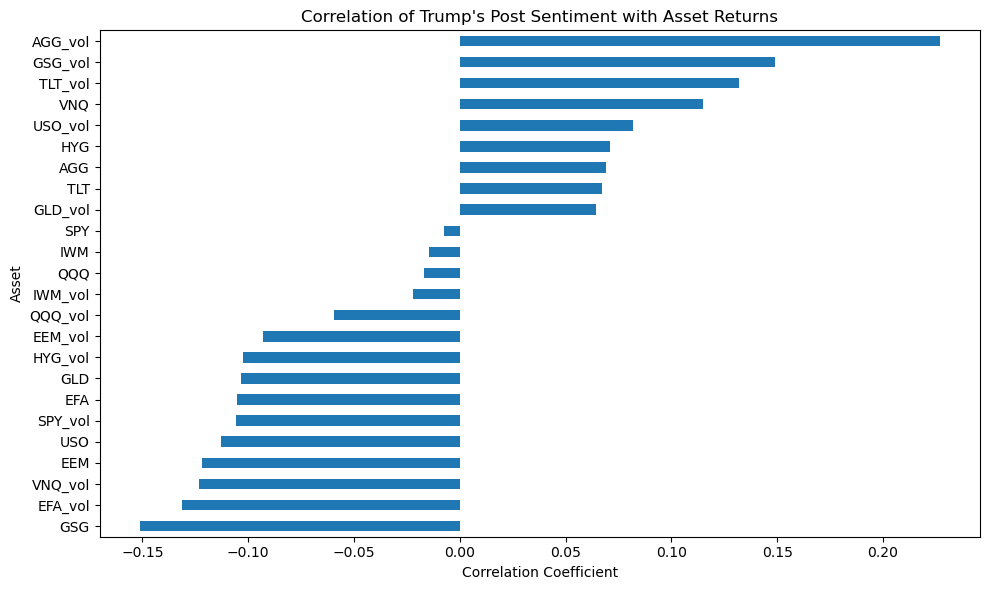

In [55]:
# Correlation Analysis
if not merged_df.empty and 'DailySentiment' in merged_df.columns:
    correlations = merged_df.corr()['DailySentiment'].drop('DailySentiment')
    print("\nCorrelation of Daily Sentiment with Asset Returns:")
    print(correlations)

    plt.figure(figsize=(10, 6))
    correlations.sort_values().plot(kind='barh')
    plt.title('Correlation of Trump\'s Post Sentiment with Asset Returns')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Asset')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping correlation analysis as merged_df is empty or 'DailySentiment' column is missing.")

In [56]:
# Regression Analysis
import statsmodels.api as sm

if not merged_df.empty and 'DailySentiment' in merged_df.columns and len(merged_df) > 1:
    print("\nRegression Analysis (Asset Return ~ Daily Sentiment + Asset Volatility):")
    
    regression_results = {}
    
    asset_columns = [col for col in price_df.columns] # Original asset tickers from price_df
    
    for asset in asset_columns:
        vol_col_name = f'{asset}_vol'
        if asset not in merged_df.columns or vol_col_name not in merged_df.columns:
            print(f"\nSkipping {asset} as its return or volatility column is not in merged_df.")
            continue

        if merged_df[asset].isnull().all() or merged_df[vol_col_name].isnull().all():
            print(f"\nSkipping {asset} due to all NaN values in return or volatility.")
            continue
            
        # Prepare data for this specific asset
        # Select relevant columns and drop rows with NaNs for this specific set of variables
        temp_df = merged_df[[asset, 'DailySentiment', vol_col_name]].dropna()

        if len(temp_df) < 3: # Need enough data points for regression with two IVs + constant
            print(f"\nSkipping {asset} due to insufficient data after NaN removal for regression (need at least 3). Has {len(temp_df)}")
            continue

        y = temp_df[asset]
        X = temp_df[['DailySentiment', vol_col_name]]
        
        X_sm = sm.add_constant(X)
        
        try:
            model = sm.OLS(y, X_sm)
            results = model.fit()
            
            regression_results[asset] = {
                'sentiment_coeff': results.params['DailySentiment'],
                'sentiment_p_value': results.pvalues['DailySentiment'],
                'volatility_coeff': results.params[vol_col_name],
                'volatility_p_value': results.pvalues[vol_col_name],
                'r_squared': results.rsquared,
                'n_obs': results.nobs
            }
            
            print(f"\nResults for {asset}:")
            print(f"  Sentiment Coefficient: {results.params['DailySentiment']:.6f} (P: {results.pvalues['DailySentiment']:.4f})")
            print(f"  Volatility ({vol_col_name}) Coefficient: {results.params[vol_col_name]:.6f} (P: {results.pvalues[vol_col_name]:.4f})")
            print(f"  R-squared: {results.rsquared:.4f}")
            print(f"  Observations: {int(results.nobs)}")
            
        except Exception as e:
            print(f"\nCould not perform regression for {asset}: {e}")
            regression_results[asset] = {'error': str(e)}
            
    regression_summary_df = pd.DataFrame.from_dict(regression_results, orient='index')
    print("\nRegression Summary Table:")
    print(regression_summary_df)
    
else:
    print("Skipping regression analysis: merged_df is empty, 'DailySentiment' is missing, or insufficient data.")



Regression Analysis (Asset Return ~ Daily Sentiment + Asset Volatility):

Results for SPY:
  Sentiment Coefficient: -0.000003 (P: 0.9837)
  Volatility (SPY_vol) Coefficient: 0.170852 (P: 0.5299)
  R-squared: 0.0029
  Observations: 142

Results for QQQ:
  Sentiment Coefficient: -0.000037 (P: 0.8421)
  Volatility (QQQ_vol) Coefficient: -0.003114 (P: 0.9910)
  R-squared: 0.0003
  Observations: 142

Results for IWM:
  Sentiment Coefficient: -0.000035 (P: 0.8692)
  Volatility (IWM_vol) Coefficient: 0.087029 (P: 0.8093)
  R-squared: 0.0006
  Observations: 142

Results for EFA:
  Sentiment Coefficient: -0.000160 (P: 0.2537)
  Volatility (EFA_vol) Coefficient: 0.329161 (P: 0.4689)
  R-squared: 0.0149
  Observations: 142

Results for EEM:
  Sentiment Coefficient: -0.000251 (P: 0.1518)
  Volatility (EEM_vol) Coefficient: 0.007866 (P: 0.9845)
  R-squared: 0.0149
  Observations: 142

Results for AGG:
  Sentiment Coefficient: 0.000019 (P: 0.6905)
  Volatility (AGG_vol) Coefficient: 0.679476 (P: 0.

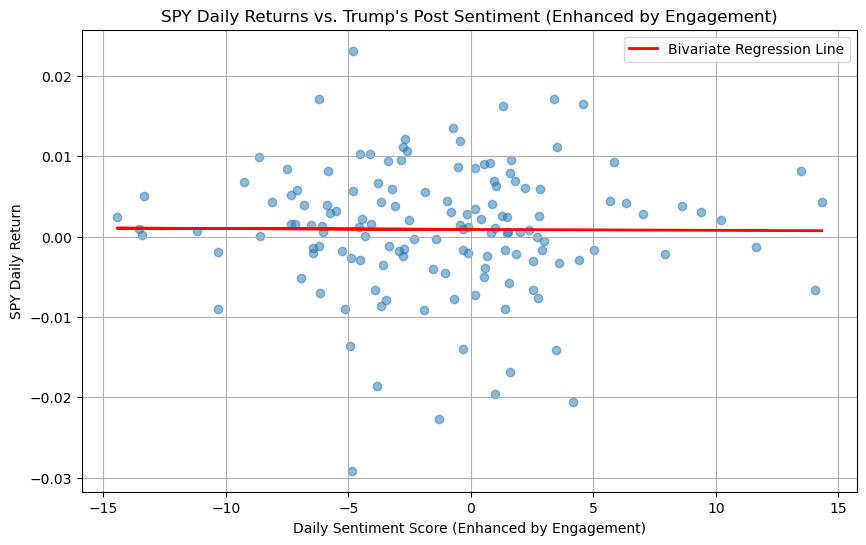

In [57]:
# Example Visualization: Scatter plot for a specific asset (e.g., SPY) vs. Enhanced Sentiment
if not merged_df.empty and 'SPY' in merged_df.columns and 'DailySentiment' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['DailySentiment'], merged_df['SPY'], alpha=0.5)
    plt.title('SPY Daily Returns vs. Trump\'s Post Sentiment (Enhanced by Engagement)')
    plt.xlabel('Daily Sentiment Score (Enhanced by Engagement)')
    plt.ylabel('SPY Daily Return')
    plt.grid(True)
    
    # Add a regression line (from a simple bivariate model for visualization)
    temp_df_spy_viz = merged_df[['SPY', 'DailySentiment']].dropna()
    if len(temp_df_spy_viz) > 1:
        X_spy_viz = sm.add_constant(temp_df_spy_viz['DailySentiment'])
        y_spy_viz = temp_df_spy_viz['SPY']
        try:
            model_spy_viz = sm.OLS(y_spy_viz, X_spy_viz).fit()
            plt.plot(temp_df_spy_viz['DailySentiment'], model_spy_viz.predict(X_spy_viz), color='red', linewidth=2, label='Bivariate Regression Line')
            plt.legend()
        except Exception as e:
            print(f"Could not fit bivariate regression line for SPY visualization: {e}")

    plt.show()
else:
    print("Skipping SPY scatter plot example as data is not available in merged_df.")